In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json, os
from dotenv import load_dotenv
from OddsJamClient import OddsJamClient
from db_utils import get_db
from models import OddsJam, OddsPortal
from models import ALL_SPORTSBOOKS
from sports import *
from datetime import datetime, timedelta
from models import OddsRecord
from tqdm import tqdm_notebook
load_dotenv()
import requests
oj = OddsJam(api_key=os.getenv("ODDSJAM_API_KEY"))
from models import OddsPortal, Game, Market, Team

## Initialize webdriver 

In [2]:
op = OddsPortal(headless=True)
op.driver.get("https://www.oddsportal.com")
cookies = pd.read_csv("./models/sportsbooks/odds_portal_cookies.tsv", sep="	")[["name","value", "domain"]].to_dict(orient="records")
[op.driver.add_cookie(cookie_dict=c) for c in cookies]
start_year=2022


## Get game links by year

In [ ]:

# all_games = []
# for start_year in range(2008, 2022):
#     games = op.get_games_by_year(start_year=start_year)
#     # pd.DataFrame.from_records([dict(g) for g in games]).to_csv(f"./data/NBA/games/{start_year}-{start_year+1}-games.csv")
#     all_games.extend(games)
# pd.DataFrame.from_records([vars(g) for g in all_games]).to_csv(f"./data/NBA/games/all-games.csv")



## Get game odds by bookie

In [ ]:
# import bson
# games_df = pd.read_csv("./data/NBA/games/all-games.csv", dtype='string', keep_default_na=False).sort_values(by="start_timestamp")

# games_df['teams'] = games_df['teams'].apply(lambda x: json.loads(x.replace("\'", "\"")))
# games_df['scores'] = games_df['scores'].apply(lambda x: json.loads(x.replace("\'", "\"")))
# games_df['metadata'] = games_df['metadata'].apply(lambda x: json.loads(x.replace("\'", "\"")))
# games_df = games_df.rename(columns={"id": "_id"})


# markets_df = pd.DataFrame()
# markets_df['_id'] = [str(bson.ObjectId()) for _ in range(len(games_df))]
# markets_df['market_name'] = "moneyline"
# markets_df['lines'] = games_df['teams'].apply(lambda x: [e + " to win" for e in x])
# markets_df['winning_line'] =  games_df['scores'].apply(lambda x: max(x, key=x.get) + " to win")
# games_df['markets'] = [[m] for m in markets_df.to_dict("records")]
# games_df.to_json("./data/NBA/games/all-games.json", "records")

In [3]:
games = Game.games_from_json('./data/NBA/games/all-games.json')
print(len(games))
odds_records = []
batch_number = 2
start_game = [g for g in games if g.metadata["url"] == "/basketball/usa/nba-2020-2021/denver-nuggets-cleveland-cavaliers-MLo9FlAM/"][0]
sorted_games = sorted(games, key=lambda x: x.start_timestamp, reverse=True)
for game in tqdm_notebook(sorted_games[sorted_games.index(start_game):]):
    try:
        odds_records.extend(op.get_game_odds(game))
    except Exception as e:
        print(e)
with open(f"./data/NBA/odds/all-odds-moneyline-{batch_number}.json", "w") as f:
    json.dump([json.loads(o.model_dump_json(by_alias=True)) for o in odds_records], f)


18930


/var/folders/6b/t83jzcrj3zj728qckvy4kj300000gn/T/ipykernel_82425/1351310456.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for game in tqdm_notebook(sorted_games[sorted_games.index(start_game):]):


  0%|          | 0/16734 [00:00<?, ?it/s]

Message: 
Stacktrace:
0   chromedriver                        0x0000000100cfe004 chromedriver + 4169732
1   chromedriver                        0x0000000100cf5ff8 chromedriver + 4136952
2   chromedriver                        0x000000010094b500 chromedriver + 292096
3   chromedriver                        0x00000001009907a0 chromedriver + 575392
4   chromedriver                        0x00000001009cb818 chromedriver + 817176
5   chromedriver                        0x00000001009845e8 chromedriver + 525800
6   chromedriver                        0x00000001009854b8 chromedriver + 529592
7   chromedriver                        0x0000000100cc4334 chromedriver + 3932980
8   chromedriver                        0x0000000100cc8970 chromedriver + 3950960
9   chromedriver                        0x0000000100cac774 chromedriver + 3835764
10  chromedriver                        0x0000000100cc9478 chromedriver + 3953784
11  chromedriver                        0x0000000100c9eab4 chromedriver + 3779252

In [30]:
# convert odds to implied probs
from utils import american_odds_to_probability
from collections import defaultdict
# map from marketsids to odds
games = Game.games_from_json("./data/NBA/games/all-games.json")
odds_records = OddsRecord.odds_from_json("./data/NBA/odds/all-odds-moneyline-1.json")
odds_records = [o for  o in odds_records if o.prices]
market_odds_map = defaultdict(list)

for o in odds_records:
    o.prices =  {bookie: american_odds_to_probability(price) for bookie, price in o.prices.items()}
    market_odds_map[str(o.market_id)].append(o)
    o.prices["average"] = sum(o.prices.values())/len(o.prices)
    
# list of (game, [oddsRecords])
games_with_odds = [(g, market_odds_map[str(g.markets[0].id)]) for g in games if str(g.markets[0].id) in market_odds_map]

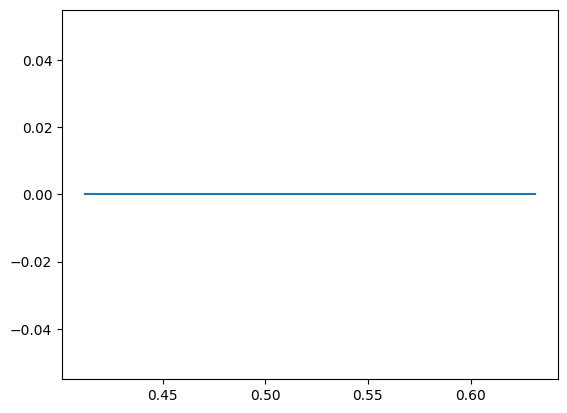

In [34]:
# plot bookmaker average odds vs. game outcome
for g, o in games_with_odds:
    bookie_avg_odds = []
    game_outcomes = []
    for o_r in o:
        if g.markets[0].winning_line == o_r.line_name:
            game_outcomes.append(1)
        else:
            game_outcomes.append(0)
        bookie_avg_odds.append(o_r.prices["average"])
plt.plot(bookie_avg_odds, game_outcomes)

In [48]:
games_with_odds[4][0].markets[0].winning_line

'Indiana Pacers to win'